<a href="https://colab.research.google.com/github/alfarzf/Deep-Learning/blob/main/CNN_FractalNet_ResNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="pV1W4C5THoTvlmPcwTw0")
project = rf.workspace("wasteclassification-lye0l").project("butterfly-9bbcw")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...


In [2]:
# prompt: checking if the imported database exist in the runtime

import os

# Check if the dataset folder exists
if os.path.exists('/content/butterfly-1'):
  print("Dataset exists in the runtime environment.")
else:
  print("Dataset does not exist in the runtime environment.")


Dataset exists in the runtime environment.


In [2]:
# prompt: declare the path for the test, train, and validation from the imported dataset

# Define the paths for train, test, and validation datasets
train_path = "/content/butterfly-1/train"
test_path = "/content/butterfly-1/test"
valid_path = "/content/butterfly-1/valid"

Class Distribution in Train Set:


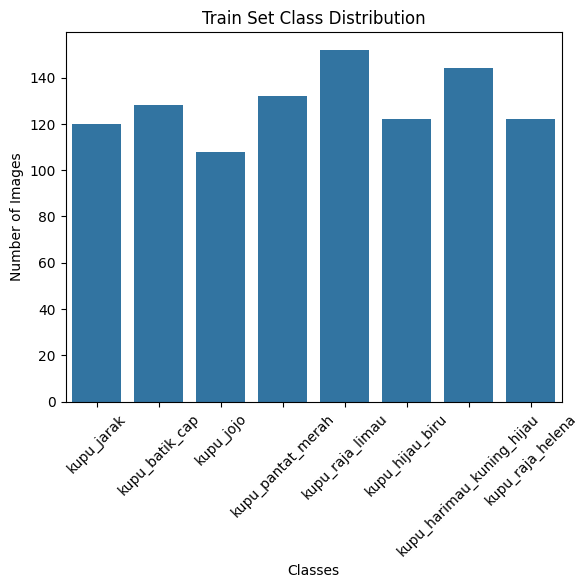

Class Distribution in Test Set:


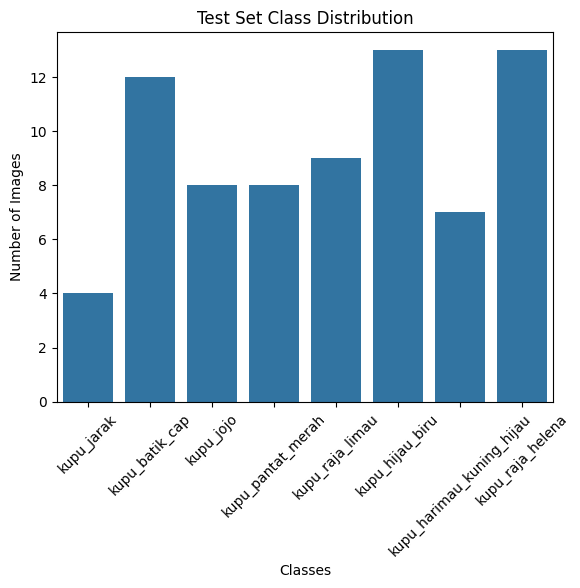

Class Distribution in Validation Set:


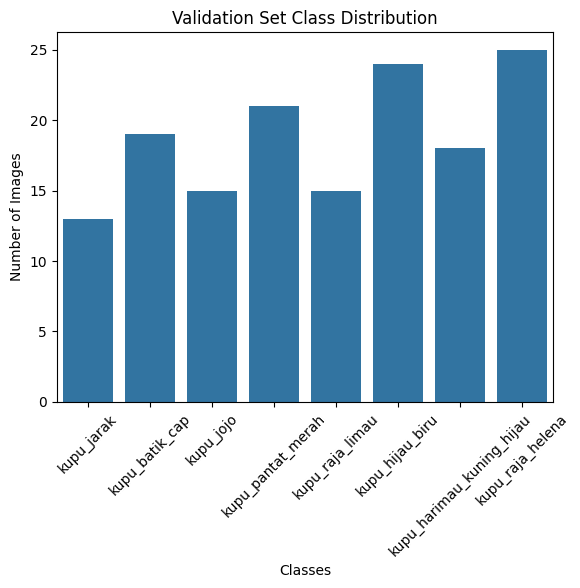

Example Images from Train Set:


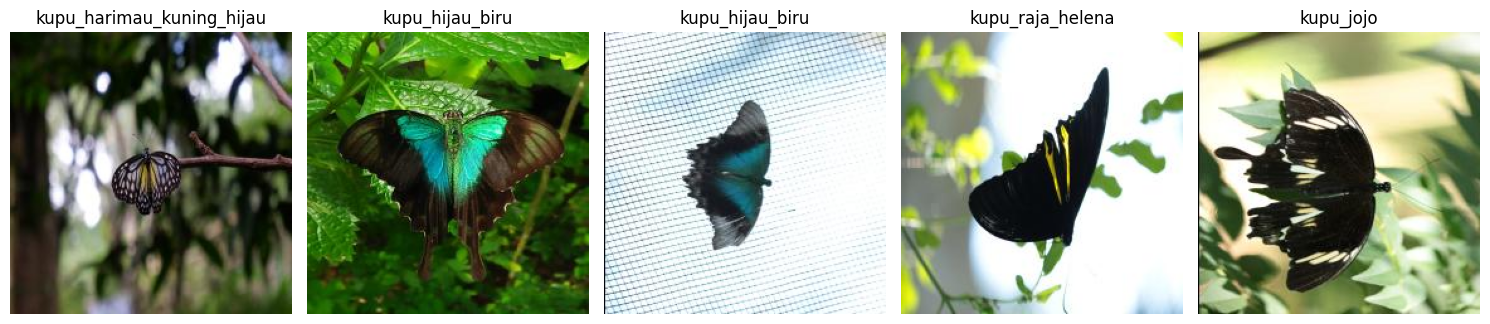

In [16]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

# Paths to dataset directories
train_path = "/content/butterfly-1/train"
test_path = "/content/butterfly-1/test"
valid_path = "/content/butterfly-1/valid"

# Function to count images in each class
def count_images_in_classes(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len([f for f in os.listdir(class_folder) if f.endswith(('jpg', 'jpeg', 'png'))])
    return class_counts

# Get class distributions
train_counts = count_images_in_classes(train_path)
test_counts = count_images_in_classes(test_path)
valid_counts = count_images_in_classes(valid_path)

# Plot class distributions
def plot_class_distribution(data, title):
    sns.barplot(x=list(data.keys()), y=list(data.values()))
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel('Number of Images')
    plt.xlabel('Classes')
    plt.show()

print("Class Distribution in Train Set:")
plot_class_distribution(train_counts, "Train Set Class Distribution")

print("Class Distribution in Test Set:")
plot_class_distribution(test_counts, "Test Set Class Distribution")

print("Class Distribution in Validation Set:")
plot_class_distribution(valid_counts, "Validation Set Class Distribution")

# Display example images
def display_examples(dataset_path, num_images=5):
    classes = os.listdir(dataset_path)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        class_name = random.choice(classes)
        class_folder = os.path.join(dataset_path, class_name)
        img_name = random.choice(os.listdir(class_folder))
        img_path = os.path.join(class_folder, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

print("Example Images from Train Set:")
display_examples(train_path)


#CNN

In [8]:
# prompt: build a simple cnn for classification task from that database

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

IMG_WIDTH = 224
IMG_HEIGHT = 224
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 64
BUFFER_SIZE = 100

# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation="nearest",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation="nearest",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Get the class names before applying prepare
num_classes = len(train_ds.class_names) # Store the number of classes here


def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (tf.image.convert_image_dtype(x, dtype=tf.float32), y),
                num_parallel_calls=BUFFER_SIZE)
    if shuffle:
        ds = ds.shuffle(BUFFER_SIZE)
    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=BUFFER_SIZE)
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=BUFFER_SIZE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax') # Use num_classes obtained earlier
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10  # Adjust as needed
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Found 1028 files belonging to 8 classes.
Found 150 files belonging to 8 classes.


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 912ms/step - accuracy: 0.2250 - loss: 2.2536 - val_accuracy: 0.5333 - val_loss: 1.3052
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.7277 - loss: 0.7701 - val_accuracy: 0.8667 - val_loss: 0.4135
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.8976 - loss: 0.3261 - val_accuracy: 0.9600 - val_loss: 0.1308
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.9480 - loss: 0.1703 - val_accuracy: 0.9533 - val_loss: 0.1489
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.9739 - loss: 0.0933 - val_accuracy: 0.9467 - val_loss: 0.2197
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.9848 - loss: 0.0593 - val_accuracy: 0.9867 - val_loss: 0.0431
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.9971 - loss: 0.0135 - val_accuracy: 0.9667 - val_loss: 0.1010
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - accuracy: 0.9984 - loss: 0.0099 - val_accur

In [15]:
# prompt: from the model in the cell above, what if i want to see its accuracy, precission,  recall, and f1-score, make it in a dataframe

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'val_ds' and 'model' are defined as in the previous code

# Make predictions on the validation set
y_pred = model.predict(val_ds)
y_pred_classes = tf.argmax(y_pred, axis=1)

# Get true labels
y_true = []
for images, labels in val_ds:
    y_true.extend(tf.argmax(labels, axis=1).numpy())

y_true = tf.constant(y_true)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro') # Use macro averaging for multiclass
recall = recall_score(y_true, y_pred_classes, average='macro') # Use macro averaging for multiclass
f1 = f1_score(y_true, y_pred_classes, average='macro') # Use macro averaging for multiclass


# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy, precision, recall, f1]
})

metrics_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


,Metric,Value
0,Accuracy,0.980000
1,Precision,0.979708
2,Recall,0.977381
3,F1-Score,0.978348


#FractalNet

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

class FractalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth):
        super(FractalBlock, self).__init__()
        self.depth = depth
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        if depth > 1:
            # Changed in_channels to out_channels for sub-blocks
            self.sub_block1 = FractalBlock(out_channels, out_channels, depth - 1)
            self.sub_block2 = FractalBlock(out_channels, out_channels, depth - 1)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        if self.depth > 1:
            path1 = self.sub_block1(x)
            path2 = self.sub_block2(x)
            return (path1 + path2) / 2
        else:
            return x


class FractalNet(nn.Module):
    def __init__(self, in_channels, num_classes, num_blocks, depth):
        super(FractalNet, self).__init__()
        self.first_block = FractalBlock(in_channels, 64, depth) # Separate first block
        self.blocks = nn.ModuleList([
            FractalBlock(64, 64, depth) for _ in range(num_blocks - 1) # Subsequent blocks with 64 in_channels
        ])
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.first_block(x) # Pass through the first block
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Reduced image size to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

# Paths to your custom dataset (adjust these paths to your dataset)
train_dir = "/content/butterfly-1/train"
valid_dir = "/content/butterfly-1/valid"
test_dir = "/content/butterfly-1/test"

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Determine number of classes based on training dataset
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Initialize the FractalNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FractalNet(in_channels=3, num_classes=num_classes, num_blocks=3, depth=4).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Validation loop
model.eval()
valid_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Loss: {valid_loss/len(valid_loader):.4f}")
print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Testing loop
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Number of classes: 8
Epoch 1/10, Loss: 1.4971
Epoch 2/10, Loss: 1.1333
Epoch 3/10, Loss: 0.9508
Epoch 4/10, Loss: 0.7615
Epoch 5/10, Loss: 0.6061
Epoch 6/10, Loss: 0.5290
Epoch 7/10, Loss: 0.4973
Epoch 8/10, Loss: 0.4712
Epoch 9/10, Loss: 0.3793
Epoch 10/10, Loss: 0.3650
Validation Loss: 0.1941
Validation Accuracy: 96.00%
Test Accuracy: 95.95%


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

def evaluate_metrics(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1, classification_report(all_labels, all_preds, target_names=train_dataset.classes)

# Testing with metrics
test_accuracy, test_precision, test_recall, test_f1, test_report = evaluate_metrics(model, test_loader, device)

print("Test Metrics:")
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1-Score: {test_f1:.2f}")
print("\nDetailed Classification Report:")
print(test_report)

Test Metrics:
Accuracy: 95.95%
Precision: 0.97
Recall: 0.96
F1-Score: 0.96

Detailed Classification Report:
                           precision    recall  f1-score   support

           kupu_batik_cap       1.00      1.00      1.00        12
kupu_harimau_kuning_hijau       1.00      1.00      1.00         7
          kupu_hijau_biru       0.93      1.00      0.96        13
               kupu_jarak       1.00      1.00      1.00         4
                kupu_jojo       1.00      0.88      0.93         8
        kupu_pantat_merah       1.00      1.00      1.00         8
         kupu_raja_helena       1.00      0.85      0.92        13
          kupu_raja_limau       0.82      1.00      0.90         9

                 accuracy                           0.96        74
                macro avg       0.97      0.97      0.96        74
             weighted avg       0.97      0.96      0.96        74



#ResNext

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNeXtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cardinality, bottleneck_width, stride=1):
        super(ResNeXtBlock, self).__init__()
        D = bottleneck_width * cardinality  # Dimensionality of the grouped convolution

        self.conv1 = nn.Conv2d(in_channels, D, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(D)

        self.conv2 = nn.Conv2d(D, D, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(D)

        self.conv3 = nn.Conv2d(D, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNeXt(nn.Module):
    def __init__(self, block, num_blocks, cardinality, bottleneck_width, num_classes=1000):
        super(ResNeXt, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, cardinality=cardinality, bottleneck_width=bottleneck_width)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, cardinality=cardinality, bottleneck_width=bottleneck_width)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, cardinality=cardinality, bottleneck_width=bottleneck_width)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, cardinality=cardinality, bottleneck_width=bottleneck_width)

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, cardinality, bottleneck_width):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, cardinality, bottleneck_width, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.pool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Paths to your dataset
train_path = "/content/butterfly-1/train"
valid_path = "/content/butterfly-1/valid"
test_path = "/content/butterfly-1/test"

# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10
num_classes = len(datasets.ImageFolder(train_path).classes)  # Automatically detects the number of classes

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(train_path, transform=transform)
valid_dataset = datasets.ImageFolder(valid_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model = ResNeXt(ResNeXtBlock, [3, 4, 6, 3], cardinality=32, bottleneck_width=4, num_classes=num_classes).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return epoch_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return epoch_loss, accuracy

# Training and Validation
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate(model, valid_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%")

# Testing
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Epoch 1/10:
  Train Loss: 1.4393, Train Acc: 48.15%
  Valid Loss: 4.1329, Valid Acc: 30.67%
Epoch 2/10:
  Train Loss: 0.4776, Train Acc: 82.20%
  Valid Loss: 0.8703, Valid Acc: 70.67%
Epoch 3/10:
  Train Loss: 0.3243, Train Acc: 89.11%
  Valid Loss: 0.2482, Valid Acc: 91.33%
Epoch 4/10:
  Train Loss: 0.2160, Train Acc: 93.48%
  Valid Loss: 0.3006, Valid Acc: 91.33%
Epoch 5/10:
  Train Loss: 0.1876, Train Acc: 93.87%
  Valid Loss: 0.0839, Valid Acc: 96.67%
Epoch 6/10:
  Train Loss: 0.1498, Train Acc: 95.91%
  Valid Loss: 0.2386, Valid Acc: 89.33%
Epoch 7/10:
  Train Loss: 0.1971, Train Acc: 93.48%
  Valid Loss: 0.4938, Valid Acc: 89.33%
Epoch 8/10:
  Train Loss: 0.1515, Train Acc: 94.84%
  Valid Loss: 0.3946, Valid Acc: 90.00%
Epoch 9/10:
  Train Loss: 0.1360, Train Acc: 95.72%
  Valid Loss: 0.5202, Valid Acc: 89.33%
Epoch 10/10:
  Train Loss: 0.1669, Train Acc: 95.23%
  Valid Loss: 0.0773, Valid Acc: 98.67%
Test Loss: 0.1141, Test Accuracy: 97.30%


In [6]:
# Validation loop
model.eval()
valid_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Loss: {valid_loss/len(valid_loader):.4f}")
print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Testing loop
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Validation Loss: 0.0746
Validation Accuracy: 98.67%
Test Accuracy: 97.30%


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

def evaluate_metrics(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1, classification_report(all_labels, all_preds, target_names=train_dataset.classes)

# Testing with metrics
test_accuracy, test_precision, test_recall, test_f1, test_report = evaluate_metrics(model, test_loader, device)

print("Test Metrics:")
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1-Score: {test_f1:.2f}")
print("\nDetailed Classification Report:")
print(test_report)


Test Metrics:
Accuracy: 97.30%
Precision: 0.98
Recall: 0.97
F1-Score: 0.97

Detailed Classification Report:
                           precision    recall  f1-score   support

           kupu_batik_cap       1.00      0.92      0.96        12
kupu_harimau_kuning_hijau       0.88      1.00      0.93         7
          kupu_hijau_biru       0.93      1.00      0.96        13
               kupu_jarak       1.00      1.00      1.00         4
                kupu_jojo       1.00      0.88      0.93         8
        kupu_pantat_merah       1.00      1.00      1.00         8
         kupu_raja_helena       1.00      1.00      1.00        13
          kupu_raja_limau       1.00      1.00      1.00         9

                 accuracy                           0.97        74
                macro avg       0.98      0.97      0.97        74
             weighted avg       0.98      0.97      0.97        74

